In [10]:
# %pip install --upgrade numpy gensim

In [121]:
import pandas as pd
import numpy as np

import re

import faiss
from gensim.models.fasttext import FastText 

,code,description,supplier_name
0,065.8000.3296,"Телевизор LED LG 43US662H Direct LED 43""",Телевизор 43US662H
1,065.8000.3297,"Телевизор LED LG 50US662H 50""",Телевизор 50US662H
2,066.5602.2128,"Коммутатор управляемый Eltex MES2348B RS-232, ...","MES2348B_AC Ethernet-коммутатор MES2348B, 48 п..."
3,035.7800.H271,Кабель прямого соединения активный 1м SFP+ - S...,"FH-DP1T30SS01 SFP+ Direct attach cable, 10G, 1m"
4,066.5602.2127,"Коммутатор управляемый Eltex MES2324B RS-232, ...","MES2324B_AC Ethernet-коммутатор MES2324B, 24 п..."
...,...,...,...
42096,045.9000.G183,"Замок (автотранспорт) двери передней, правый A...",ЗАМОК ДВЕРИ ПРАВЫЙ ОАО ГАЗ А21R23.6105012
42097,045.9000.G149,Защелка 2705.8213109 автомобиль ГАЗ,ЗАЩЕЛКА ЗАМКА ПР ОАО ГАЗ 2705.8213109
42098,045.9000.G160,Защелка 2705-8213110 автомобиль ГАЗ,ЗАЩЕЛКА ЗАМКА ЛЕВ ОАО ГАЗ 2705.8213110
42099,045.9000.G184,"Замок (автотранспорт) двери передней, правый A...",ЗАМОК ДВЕРИ ЛЕВЫЙ ОАО ГАЗ А21R23.6105013


In [122]:
ref = pd.read_csv('clean_ref.csv')
pairs = pd.read_csv('clean_train.csv')

0    вода техническая дистиллированная 1.5л
1     вода техническая дистиллированная 10л
2      вода техническая дистиллированная 1л
3      вода техническая дистиллированная 4л
4      вода техническая дистиллированная 5л
Name: description, dtype: object

In [123]:
# https://github.com/gorodion/Goods-Classifier/blob/master/summary.ipynb

def normalize(ser: pd.Series):
#   "СокДобрый" -> "Сок Добрый"
    camel_case_pat = re.compile(r'([а-яa-z])([А-ЯA-Z])')
# #   "lmno" -> "лмно"
#     trans_table = make_trans()
# #   "14х15х30" -> "DxDxD"
#     dxdxd_pat = re.compile(r'((?:\d+\s*[х\*]\s*){2}\d+)')
#   "1.2 15,5" -> "1p2 15p5"  
    digit_pat = re.compile(r'(\d+)[\.,](\d+)')
#   "15 мл" -> "15мл"
    unit = 'мг|г|гр|кг|мл|л|шт'
    unit_pat = re.compile(fr'((?:\d+p)?\d+)\s*({unit})\b')
# #   "ж/б ст/б" -> "жб стб"
#     w_w_pat = re.compile(r'\b([а-я]{1,2})/([а-я]{1,2})\b')
# #   "a b c d" -> "abcd"
#     glue_pat = re.compile(r'(?<=(?<!\w)\w) (?=\w(?!\w))', re.UNICODE)
    
    return ser \
            .str.replace(camel_case_pat, r'\1 \2', regex=True) \
            .str.lower() \
            .str.replace(r'ъ\b', '', regex=True) \
            .str.replace('№', ' NUM ') \
            .str.replace('%', ' PERC ') \
            .str.replace(digit_pat, r' \1p\2 ', regex=True) \
            .str.replace(unit_pat, r' \1\2 ', regex=True) \
            .str.replace(r'[\W_]', ' ', regex=True)

In [124]:
ref['norm_desc'] = normalize(ref['description'])

In [125]:
ref[['description', 'norm_desc']]

,description,norm_desc
0,Вода техническая дистиллированная 1.5л,вода техническая дистиллированная 1p5л
1,Вода техническая дистиллированная 10л,вода техническая дистиллированная 10л
2,Вода техническая дистиллированная 1л,вода техническая дистиллированная 1л
3,Вода техническая дистиллированная 4л,вода техническая дистиллированная 4л
4,Вода техническая дистиллированная 5л,вода техническая дистиллированная 5л
...,...,...
293564,Комплект оборудования расширения модульного ко...,комплект оборудования расширения модульного ко...
293565,Комплект оборудования спортивно-технологическо...,комплект оборудования спортивно технологическо...
293566,Товары канцелярские МРФ Центр,товары канцелярские мрф центр
293567,Место грузовое,место грузовое


In [126]:
model = FastText(ref['norm_desc'].apply(lambda x: [w for w in x.split(' ') if len(w) > 0]), vector_size=128, window=5, workers=12, epochs=10, sg=1, bucket=400_000)

In [127]:
model.wv.most_similar('телевизор')

[('телевизора', 0.9302962422370911),
 ('телевизоров', 0.8773584961891174),
 ('ревизор', 0.8665978908538818),
 ('1366x768пикс', 0.8039826154708862),
 ('жидкокристалический', 0.7906965017318726),
 ('1024x768пикс', 0.783322274684906),
 ('жидкокристаллический', 0.7815370559692383),
 ('1366x768', 0.763545572757721),
 ('t2c', 0.7413266897201538),
 ('32lem', 0.7326191663742065)]

In [128]:
model.save('2_fasttext/ft_128_10e.model')

True


'вода техническая дистиллированная   1p5л '

In [172]:
data = ref['norm_desc'].apply(lambda x: [w for w in x.split(' ') if len(w) > 0]).apply(model.wv.get_mean_vector).values

In [173]:
data = np.vstack(data)

In [131]:
index = faiss.IndexFlatL2(128)   # build the index
print(index.is_trained)
index.add(data)                  # add vectors to the index
print(index.ntotal)

True
293569


In [133]:
ref['index'] = ref.index

In [137]:
pairs = pairs \
            .merge(ref[['index', 'description']], on='description') \
            .rename(columns={'index': 'reference_index'})

In [139]:
pairs['norm_desc'] = normalize(pairs['description'])
pairs['norm_supp'] = normalize(pairs['supplier_name'])

In [153]:
N = 10

supp_vectors = pairs['norm_supp'] \
                .apply(lambda x: [w for w in x.split(' ') if len(w) > 0]) \
                .apply(model.wv.get_mean_vector).values

supp_vectors = np.vstack(supp_vectors)
dist, ids = index.search(supp_vectors, N)

In [154]:
# tmp = pairs.head().copy()
pairs[[f'best_{i}_dist' for i in range(N)]] = dist
pairs[[f'best_{i}_item' for i in range(N)]] = ids

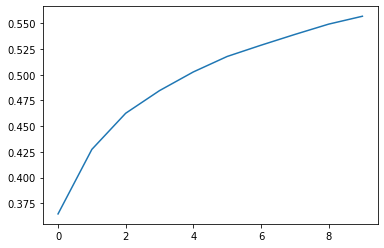

In [163]:
coinside = pairs['best_0_item'] == pairs['reference_index']
res = [coinside.mean()]
for i in range(1, 10):
    coinside = coinside | (pairs[f'best_{i}_item'] == pairs['reference_index'])
    res.append(coinside.mean())
    
plt.plot(res)

In [161]:
confs = np.linspace(0, 0.2)
acc = np.zeros_like(confs)
rec = np.zeros_like(confs)

for i, x in enumerate(confs):
    conf_enough = pairs['best_0_dist'] < x
    rec[i] = conf_enough.mean()
    acc[i] = (pairs['best_0_item'] == pairs['reference_index'])[conf_enough].mean()

In [159]:
import matplotlib.pyplot as plt

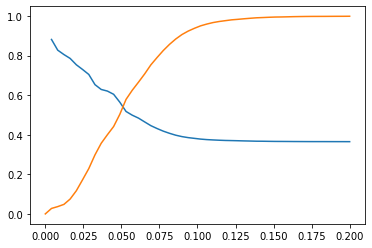

In [162]:
plt.plot(confs, acc)
plt.plot(confs, rec)

In [166]:
data.shape

(293569, 128)

In [171]:
faiss.normalize_L2(data)

In [174]:
## Now cosine similarity

In [184]:
index = faiss.IndexFlatIP(128)
print(index.is_trained)
faiss.normalize_L2(data)
index.add(data)                  # add vectors to the index
print(index.ntotal)

N = 10

supp_vectors = pairs['norm_supp'] \
                .apply(lambda x: [w for w in x.split(' ') if len(w) > 0]) \
                .apply(model.wv.get_mean_vector).values

supp_vectors = np.vstack(supp_vectors)
faiss.normalize_L2(supp_vectors)
dist, ids = index.search(supp_vectors, N)

True
293569


In [186]:
# tmp = pairs.head().copy()
pairs[[f'best_{i}_dist' for i in range(N)]] = dist
pairs[[f'best_{i}_item' for i in range(N)]] = ids

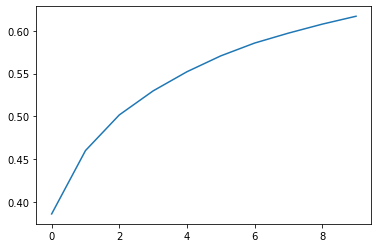

In [187]:
coinside = pairs['best_0_item'] == pairs['reference_index']
res = [coinside.mean()]
for i in range(1, 10):
    coinside = coinside | (pairs[f'best_{i}_item'] == pairs['reference_index'])
    res.append(coinside.mean())
    
plt.plot(res)

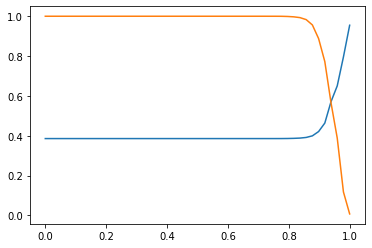

In [194]:
confs = np.linspace(0, 1)
acc = np.zeros_like(confs)
rec = np.zeros_like(confs)

for i, x in enumerate(confs):
    conf_enough = pairs['best_0_dist'] > x
    rec[i] = conf_enough.mean()
    acc[i] = (pairs['best_0_item'] == pairs['reference_index'])[conf_enough].mean()
    
plt.plot(confs, acc)
plt.plot(confs, rec)

In [193]:
conf_enough = pairs['best_0_dist'] > 0.9
conf_enough.mean(), (pairs['best_0_item'] == pairs['reference_index'])[conf_enough].mean()

(0.8788627348519038, 0.4240966460365936)

In [197]:
model.wv['one']

array([ 0.21461497,  0.10066177, -0.45537886, -0.19529827,  0.02818863,
       -0.26510102, -0.2974241 , -0.04980391,  0.28667042,  0.06244281,
        0.36384562, -0.4402903 , -0.8664536 ,  0.81610614, -0.91009325,
       -0.05410856, -0.04033682,  0.5839886 , -0.4889367 ,  0.9308116 ,
        0.71179837,  0.02207216, -0.7537576 ,  0.1026753 ,  0.22992785,
       -0.06897442,  0.37258554, -0.23481815,  0.04179269,  0.09184567,
       -0.14377901, -0.11775664,  0.60678905, -0.2821352 ,  0.31922585,
        0.15161446,  0.10545917,  0.1439633 , -0.10046177,  0.22665064,
       -0.02884221,  0.22417314, -0.74893665, -0.02073671, -0.08903249,
       -0.26029584, -0.9922718 ,  0.21048506,  0.06655484,  0.33735028,
        0.11592984, -0.42562696, -0.24809323, -0.34167147,  0.07274075,
        0.09461175,  0.43185347, -0.48093638,  0.14268287, -0.35808462,
        0.71893317, -0.9902652 , -0.49441916, -0.42637414,  0.33905432,
        0.43795362, -0.10015311,  0.61282617,  0.23518567, -0.71